***Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing***

_Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy._
_Be sure to vary the hyperparameters of your MLP!_

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing, decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Read and import data
data = pd.read_csv('breastcancerdata.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
#Check the columns in the raw data
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [4]:
#Check the kind of variables in the raw data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [5]:
#deleting the "id" column
data.drop("id",axis=1,inplace=True)
#deleting the "Unnamed: 32" column
data.drop("Unnamed: 32",axis=1,inplace=True) 

In [6]:
#Check variables type after deleting the ones we are not using
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 n

In [7]:
#counting the diagnosis variable
data.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [8]:
#Transform classifying variable into numeric variable [0,1] and add a column
data.loc[data['diagnosis'] == 'M', 'Diagclass'] = 1
data.loc[data['diagnosis'] == 'B', 'Diagclass'] = 0

#Check dataset
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Diagclass
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1.0
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1.0
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1.0
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1.0
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1.0


In [9]:
#Dataset with new classifying variable "Diagclass" and withouth the diagnosis column
data.drop("diagnosis",axis=1,inplace=True)

In [10]:
#counting the diagnosis variable
data.Diagclass.value_counts()

0.0    357
1.0    212
Name: Diagclass, dtype: int64

In [11]:
#UPsample the minority class 

# Separate majority and minority classes
Diagclass_majority = data[data.Diagclass==0]
Diagclass_minority = data[data.Diagclass==1]
 
# Downsample Diaclass majority
Diagclass_majority_downsampled = resample(Diagclass_majority, replace=False, n_samples=212, random_state=123) 
 
# Combine majority class with downsampled najority class
data1 = pd.concat([Diagclass_majority_downsampled, Diagclass_minority])
 
# Display new class counts
data1.Diagclass.value_counts()

1.0    212
0.0    212
Name: Diagclass, dtype: int64

In [12]:
#Define predictors and predicted variables

X = data1.drop('Diagclass', axis = 1)
Y = data1['Diagclass']

In [13]:
#Preprocess and scale data
names = X.columns
X1 = pd.DataFrame(preprocessing.scale(X), columns = names)
X1.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.956598,-0.958038,-0.913282,-0.872491,-0.969602,-0.000376,-0.006668,-0.697853,-0.088861,1.356285,...,-1.024784,-1.188043,-0.967787,-0.882992,-1.047159,0.046622,0.012035,-0.645890,-1.247672,1.032811
1,-1.583078,-0.897986,-1.485759,-1.261459,-0.202170,0.228499,-0.101747,-0.806465,-1.886917,1.234636,...,-1.539214,-1.487627,-1.428643,-1.176236,-0.721886,-0.513025,-0.682571,-1.291279,-2.019485,-0.409368


***PCA Analysis***

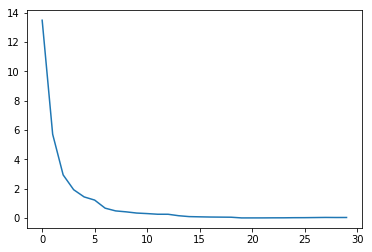

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [  6.14751572e-01   2.06951967e-01   9.27501027e-02   3.87369266e-02
   2.01461419e-02   1.16794352e-02   5.99447302e-03   2.83201672e-03
   1.98332083e-03   1.37275536e-03   9.57200397e-04   8.51675019e-04
   3.88770210e-04   2.98866290e-04   1.08971366e-04   5.21596739e-05
   4.29142907e-05   3.18389467e-05   2.26298702e-05   1.45550946e-05
   1.16946836e-05   1.00308463e-05   3.98949098e-06   3.47502492e-06
   1.67783563e-06   7.79036138e-07   4.58220614e-08   1.19299345e-08
   2.68822775e-09   1.38496983e-32]


In [14]:
# Build up the correlation mtrix
Z = X1
correlation_matrix = Z.corr()

#Eigenvectores & Eigenvalues

eig_vals, eig_vecs = np.linalg.eig(correlation_matrix)

sklearn_pca = PCA(n_components=len(Z.columns))
Y_sklearn = sklearn_pca.fit_transform(correlation_matrix)

#From the Scree plot.

plt.plot(eig_vals)
plt.show()

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

In [15]:
#PCA features

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X1)

# Create a PCA object from Scree plot the number of components is 3
pca = decomposition.PCA(n_components=3)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

# View the new feature data's shape
X_std_pca.shape

# Create a new dataframe with the new features

XPCA = pd.DataFrame(X_std_pca)
XPCA.head()

,0,1,2
0,-1.003006,3.481583,2.415757
1,-2.537136,3.404853,3.962812
2,-4.211706,-1.580275,1.245082
3,-4.484037,1.242662,0.422837
4,-2.740544,0.808732,-1.005692


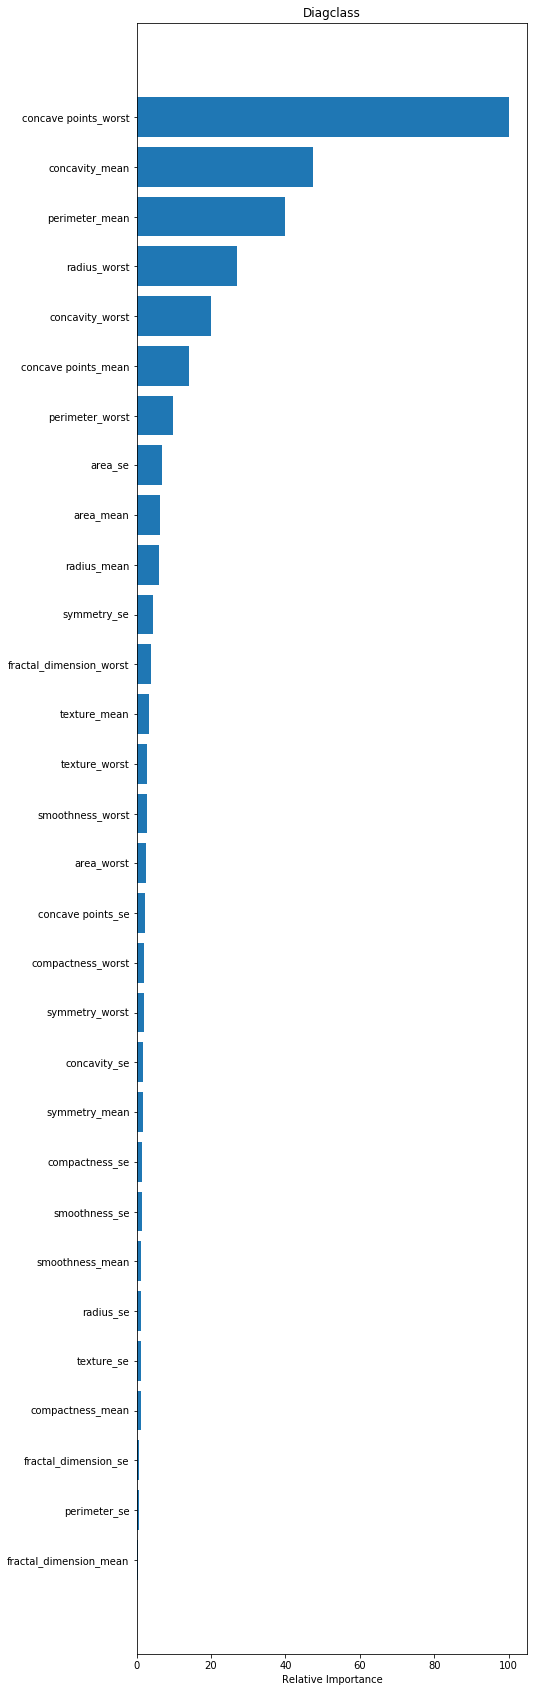

In [16]:
#Calculate Feature Importance using Random Forest
rf = RandomForestClassifier()
rf.fit(X1, Y)

#Define feature importance
feature_importance = rf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(7, 30))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X1.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Diagclass')
plt.show()

In [17]:
#Feature Selection. Scores for the most relevant features (should we start with the one that has more explanatory power)

# feature extraction
test = SelectKBest()
fit = test.fit(X1, Y)

#Identify features with highest score from a predictive perspective (for all programs)
names2 = X1.columns
Bestfeatures = pd.DataFrame(fit.scores_, index = names2)
Bestfeatures.columns = ['Best Features']
Bestfeatures.sort_values(by=['Best Features'], ascending=False)

,Best Features
concave points_worst,778.324989
perimeter_worst,597.008511
concave points_mean,590.535896
radius_worst,565.973575
perimeter_mean,477.235649
radius_mean,443.106946
concavity_worst,430.025210
concavity_mean,408.012843
area_worst,407.719036
area_mean,365.352404


In [18]:
# create the RFE model and select features

#From PCA analyis the number of components is 3

nfeatures = 3
lr = LogisticRegression()
rfe = RFE(lr,nfeatures)
fit = rfe.fit(X1,Y)

# summarize the selection of the features

result_RFE = pd.DataFrame(list(zip(X1.head(0), rfe.ranking_, rfe.support_)),columns=['Features','Ranking','Support'] )
result_RFE.sort_values('Ranking')

,Features,Ranking,Support
22,perimeter_worst,1,True
20,radius_worst,1,True
27,concave points_worst,1,True
10,radius_se,2,False
21,texture_worst,3,False
23,area_worst,4,False
24,smoothness_worst,5,False
0,radius_mean,6,False
26,concavity_worst,7,False
13,area_se,8,False


***Feature Selection***

In [19]:
#View all the predictors to make the feature selection
X1.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [20]:
#Feature Selection using Random Forest
X3 = X1[['perimeter_worst', 'area_worst', 'concave points_mean', 'concavity_mean','radius_worst','perimeter_mean',
'concavity_worst', 'compactness_mean','concave points_worst','compactness_worst']]

#Feature Selection using RFE & PCA
X2 = X1[['radius_worst','concave points_worst','perimeter_worst']]

In [21]:
#Split the data into training and testing datasets. Split: 70/30; train/test

X_train, X_test, y_train, y_test = train_test_split(X2,Y, test_size=0.3, random_state=123)

#Initiating the cross validation generator, N splits = 5

kf = KFold(5)

***Random Forest***

In [32]:
# Initialize the model

rf = RandomForestClassifier(n_jobs = -1)

#Create range of values to fit parameters

k1 = [20,100,300]

parameters = {'n_estimators':k1}

#Fit parameters

rf1 = GridSearchCV(rf, param_grid=parameters, cv=kf)

#Fit the tunned model
rf1.fit(X_train, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", rf1.best_params_)

Best Hyper Parameters: {'n_estimators': 20}


In [33]:
#Fit in test dataset
rf1.fit(X_test, y_test)

#Predict on test dataset
predtestrf_y = rf1.predict(X_test)

In [34]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestrf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestrf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestrf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

accrf1 = cross_val_score(rf1,X_test,y_test,cv=kf).mean()
accrf1pca = cross_val_score(rf1,XPCA,Y,cv=kf).mean()

print((
    'Random Forest accuracy:{}\n'
    'Random Forest accuracy PCA:{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(accrf1,accrf1pca,test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        64
          1       1.00      1.00      1.00        64

avg / total       1.00      1.00      1.00       128

[[64  0]
 [ 0 64]]
Random Forest accuracy:0.9295384615384616
Random Forest accuracy PCA:0.9363585434173668
Percent Type I errors: 0.0
Percent Type II errors: 0.0


***Gradient Boosting***

In [41]:
# Train model

GBC = GradientBoostingClassifier()

k1 = ['deviance','exponential']
k2 = np.arange(100)+1
k5 = ['friedman_mse','mse','mae']

parameters = {'loss': k1,
             'n_estimators': k2,
             'criterion': k5}

#Fit parameters

GBC1 = GridSearchCV(GBC, param_grid=parameters, cv=kf)

#Fit the tunned model
GBC1.fit(X_train, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", GBC1.best_params_)

Best Hyper Parameters: {'criterion': 'mae', 'loss': 'deviance', 'n_estimators': 32}


In [42]:
#Fit on the test set
GBC1.fit(X_test, y_test)

# Predict on test set

predtestgb_y = GBC1.predict(X_test)

In [43]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestgb_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestgb_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestgb_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

accGBC1 = cross_val_score(GBC1,X_test,y_test,cv=kf).mean()
accGBC1pca = cross_val_score(GBC1,XPCA,Y,cv=kf).mean()

print((
    'Gradient Boosting accuracy:{}\n'
    'Gradient Boosting accuracy PCA:{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(accGBC1,accGBC1pca,test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        64
          1       1.00      1.00      1.00        64

avg / total       1.00      1.00      1.00       128

[[64  0]
 [ 0 64]]
Gradient Boosting accuracy:0.8975384615384616
Gradient Boosting accuracy PCA:0.9151820728291318
Percent Type I errors: 0.0
Percent Type II errors: 0.0


***Neural Network***

In [23]:
# Initialize and fit the model.
mlp = MLPClassifier(max_iter=1000, tol=0.01)

#Tune hyperparameters
#Create range of values to fit parameters

hidden_layer_sizes= [(50,),(100,),(1000,),(1000,10),(100,20)]

alpha  = 10.0 ** -np.arange(1, 3)

activation = ['identity', 'logistic', 'tanh', 'relu']

parameters = {'hidden_layer_sizes': hidden_layer_sizes,
             'alpha': alpha,
             'activation': activation}

#Fit parameters using gridsearch
mlp_tuned = GridSearchCV(mlp, param_grid=parameters, cv=5)

#Fit the tunned model
mlp_tuned.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.01, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(50,), (100,), (1000,), (1000, 10), (100, 20)], 'alpha': array([ 0.1 ,  0.01]), 'activation': ['identity', 'logistic', 'tanh', 'relu']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
#Fit on the test set
mlp_tuned.fit(X_test, y_test)

# Predict on test set

predtest_y = mlp_tuned.predict(X_test)

In [25]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtest_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtest_y)
print(cnf)

table_test = pd.crosstab(y_test, predtest_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

accmlp = cross_val_score(mlp_tuned,X_test,y_test,cv=kf).mean()
accmlppca = cross_val_score(mlp_tuned,XPCA,Y,cv=kf).mean()

print((
    'MLP accuracy:{}\n'
    'MLP accuracy PCA:{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(accmlp,accmlppca,test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95        64
          1       1.00      0.89      0.94        64

avg / total       0.95      0.95      0.95       128

[[64  0]
 [ 7 57]]
MLP accuracy:0.9375384615384617
MLP accuracy PCA:0.9410084033613446
Percent Type I errors: 0.0
Percent Type II errors: 0.0546875


In [27]:
#Print the best parameters
print(mlp_tuned.best_params_)    

{'activation': 'identity', 'alpha': 0.10000000000000001, 'hidden_layer_sizes': (100, 20)}


***Conclusion***

A multi-layer perceptron neural network model has been set up to predict on the labeled Breast Cancer diagnosis dataset. In this case, hyperparameters regarding the activation, alpha and the hidden layer sizes have been tuned achieving an accuracy of 94%. The model is a multilayered MLP (size 2 with 100, 20 neurons respectively has been set up with an alpha parameter of 0.1 that uses identity as an activartion function.

Compared to the accuracy that has been achieved with Random Forest (93%) and Gradient Bossting (89%), the complexity of the model is much higher in the case of the MLP. Additionally, the hyperparameter tuning is much more restricted than in the case of the Random Forest and Gradient Boosting due to computational restrictions.